In [1]:
import sys
import glob
import os
import pandas as pd
import ee
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from datetime import datetime as dt
from sklearn.ensemble import RandomForestRegressor

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [18,16]
ee.Initialize()

In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

In [5]:
df = pd.read_csv("../data/all_dat_desc.csv")

In [6]:
df.rename(columns={ df.columns[0]: "site" }, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)

In [7]:
df = df.set_index(pd.to_datetime(df.date))

In [8]:
# Remove outliers
df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

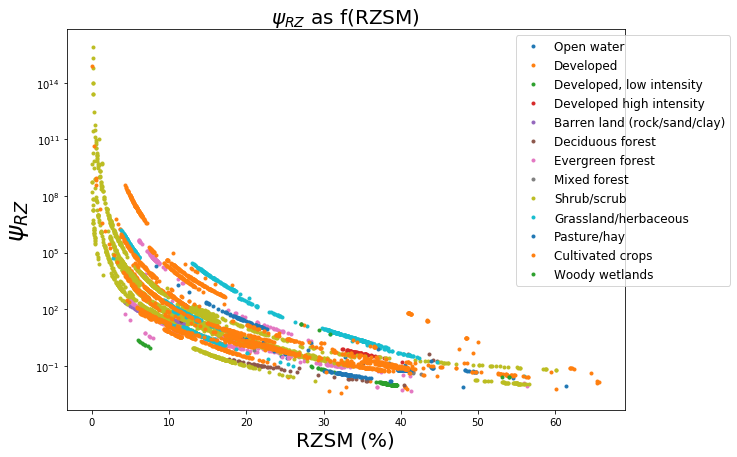

In [9]:
groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.rzsm, group.psi_rz, marker='o', linestyle='', ms=3, label=nlcd[name])
    
ax.legend(bbox_to_anchor=(1.2, 1),prop={'size': 12})
ax.set_title("$\psi_{RZ}$ as f(RZSM)", size = 20)
ax.set_ylabel("$\psi_{RZ}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("RZSM (%)", size = 20)

plt.show()

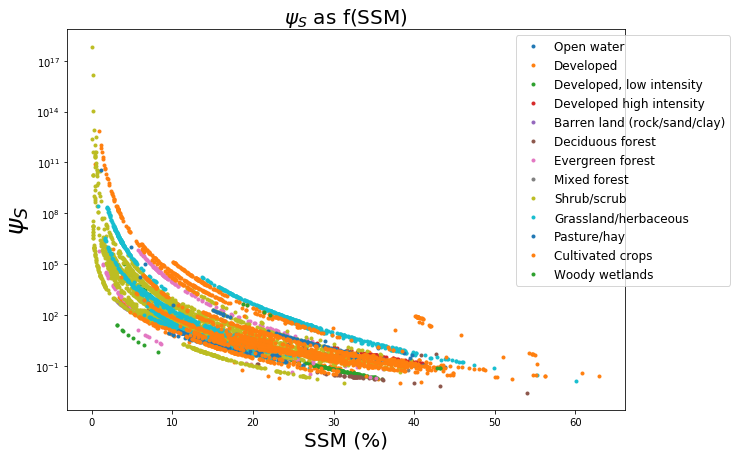

In [10]:
groups = df.groupby('lc_type')

fig, ax = plt.subplots(figsize=(10,7))

for name, group in groups:
    ax.plot(group.ssm, group.psi_s, marker='o', linestyle='', ms=3, label=nlcd[name])
    
ax.legend(bbox_to_anchor=(1.2, 1),prop={'size': 12})
ax.set_title("$\psi_{S}$ as f(SSM)", size = 20)
ax.set_ylabel("$\psi_{S}$", size = 25)
ax.set_yscale("log")
ax.set_xlabel("SSM (%)", size = 20)

plt.show()

In [11]:
site_lens = {}
lc_col = {}
for i in df.site.unique():
    sdf = df[df.site==i]
    site_lens[i] = (len(sdf))
    lc_col[i]= nlcd[sdf.lc_type[0]]

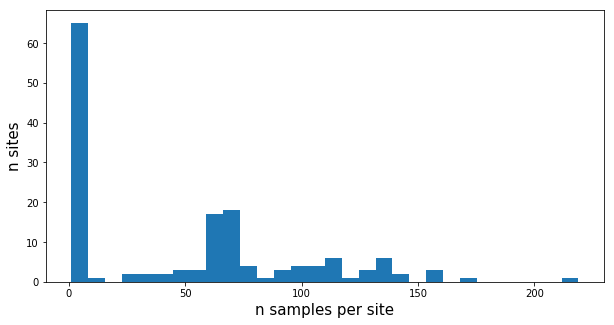

In [12]:
plt.figure(figsize = (10,5))
plt.hist(np.array(list(site_lens.values())), bins = 30)[-1]
plt.xlabel("n samples per site", size = 15)
plt.ylabel("n sites", size = 15)
plt.show()

In [13]:
t = pd.DataFrame.from_dict(list(site_lens.items()))
t.columns = ['site_id', 'len']

t2 = pd.DataFrame.from_dict(list(lc_col.items()))
t2.columns = ['site_id', 'type']

t = pd.merge(t,t2, on = "site_id")
# t.set_index('site_id', inplace = True);

In [14]:
gdf = pd.merge(sites,t,how = "inner", left_index = True, right_index = True)

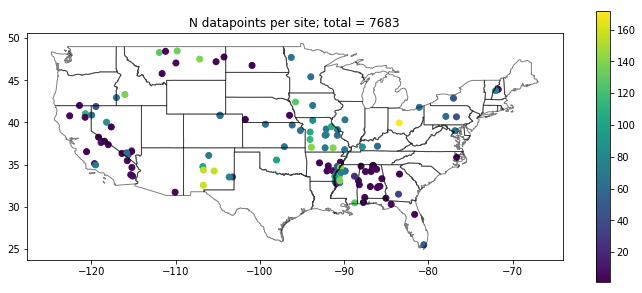

In [15]:
fig, ax = plt.subplots(figsize = (12,5))

ax.set_title("N datapoints per site; total = {}".format(sum(site_lens.values())))
gdf.plot(ax = ax, column = "len", legend = True)
states.plot(ax = ax, color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)
plt.show()

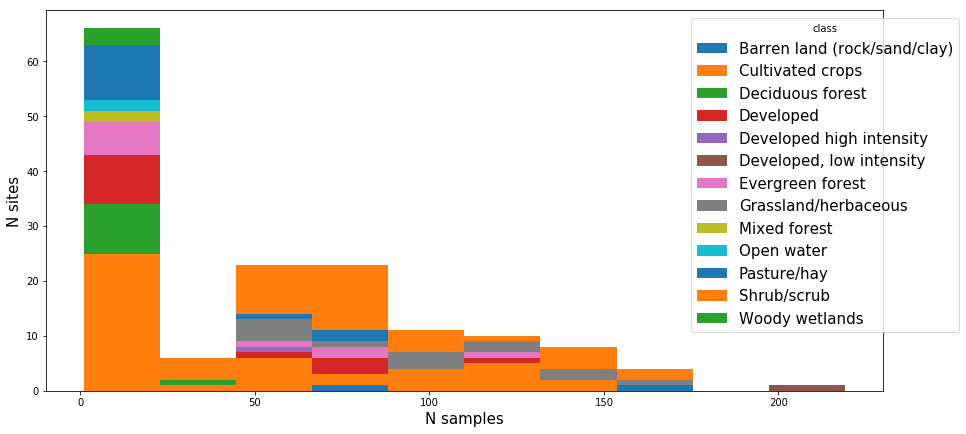

In [16]:
# Stacked histogram colored by landcover type
plt.figure(figsize=(15,7))

_, edges = np.histogram(t["len"], bins=10)
histdata = []; labels=[]
for n, group in t.groupby("type"):
    histdata.append(np.histogram(group["len"], bins=edges)[0])
    labels.append(n)

hist = np.array(histdata) 
histcum = np.cumsum(hist,axis=0)

plt.bar(edges[:-1],hist[0,:], width=np.diff(edges)[0],
            label=labels[0], align="edge")

for i in range(1,len(hist)):
    plt.bar(edges[:-1],hist[i,:], width=np.diff(edges)[0],
            bottom=histcum[i-1,:],label=labels[i], align="edge")

plt.legend(title="class", bbox_to_anchor=(1.1, 1), prop={'size': 15})
plt.ylabel("N sites", size = 15)
plt.xlabel("N samples", size = 15)
plt.show()

In [17]:
D = {}
for k,v in nlcd.items():
    t = df[df.lc_type == k]
    if len(t) == 0:
        continue
    else:
        D[v] = len(t)

Text(85.875, 0.5, 'n samples')

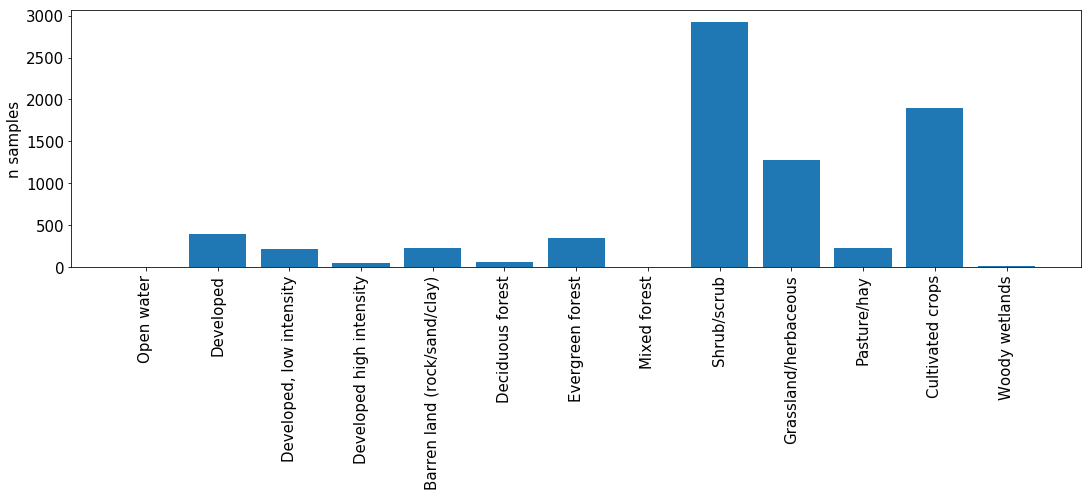

In [18]:
plt.figure(figsize = (15,7))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()), rotation='vertical', size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.ylabel("n samples", size = 15)

In [19]:
# Now: Calculate spectral indices, do ML

In [20]:
# RF / RNN

In [21]:
df = df.dropna()

In [22]:
# One hot encode the landcover types 
one_hot = pd.get_dummies(df.lc_type, drop_first=True )

In [23]:
# Select dependent variable, drop fluff from input (independent) feats
y = df.psi_rz # Psi_RZ? 
X = df.drop(["site","date","rzsm", "ssm", "psi_rz", "psi_s", "lc_type"], axis=1)

In [25]:
# Train test split for validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale inputs
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
# Concat the one hot df to the scaled df
X = pd.concat([X, one_hot], axis = 1)

In [ ]:
# Run the actual RF 

regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Make predictions on test data using the model trained on original data
predictions = regressor.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')